Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Содержание
### [1. Подготовка данных](#section_id1)
### [2. Обучение моделей](#section_id2)
####    [2.1. Градиентный бустинг CatBoost](#section_id3)
####   [2.2. Случайный лес](#section_id4)
####    [2.3. Градиентный бустинг LightGBM](#section_id5)
### [3. Анализ моделей](#section_id6)

<a id = 'Подготовка данных'></a>

<a id='section_id1'></a>

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Имеем около 50 тыс пропусков в типе кузовов авто (можно попробовать заполнить их, сравнивая с маркой авто и моделью (например, Фольцсваген Гольф сразу относится в типу кузова хэтчбек))<br>
GearBox - около 20 тыс пропусков (тут также необходимо сравнивать с маркой авто и его мощностью)<br>
Model - 20 тыс пропусков (тут обратная задача к типу автомобильного кузова=) по марке и типу кузова попробуем что нибудь да заполнить)<br>
NotRepaired была в ремонте или нет (любая машина ломается, можно поставить условие, если машина до 2008 года то не была в ремонте, иначе была, и нужно еще учесть пробег авто (если меньше 120 то не была иначе была))

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Цена авто варьируется от 0 до 20000 евро (Bugatti или Rolls-Royce тут видимо отсутсвует). Смущает, что имеются авто с нулевой ценой, можн заполнить их медианой.<br>
Год регистрации авто от 1000 до 9999, что явно ошибки, с мощностью тоже какие то ошибки (о и 20000 л.с, кто то продает ракеты=)).<br>
Никто не выкладывает фото, т.е. можем убрать данный признак из нашего датафрейма, почтовый индекс нам тоже не поможет в обучении.

In [5]:
#проверим корреляцию
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Самые сильные корреляции это зависимость цены авто от мощности и пробега. В остальном не очень сильно зависят.

In [6]:
#удалим все авто ниже 1900 и выше 2020, их будет немного
year = df.loc[((df['RegistrationYear']>2020)|(df['RegistrationYear']<1900))]
df = df.drop(year.index)
df.shape

(354198, 16)

In [7]:
#удалим столбец признак с фото и почтовый индекс, дата объявления, последний просмотр (для машинного обучения нам они не понадобятся)
df = df.drop(['NumberOfPictures', 'PostalCode', 'RegistrationMonth', 'DateCreated', 'LastSeen', 'DateCrawled'], axis = 1)

In [8]:
#определим сумму дубликатов
df.duplicated().sum()

45031

Имеем 45031 дубликат, их нужно удалять, ибо модель будет обучаться на одинаковых данных

In [9]:
df = df.drop_duplicates().reset_index(drop=True)#удалим дубликаты


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309167 entries, 0 to 309166
Data columns (total 10 columns):
Price               309167 non-null int64
VehicleType         274770 non-null object
RegistrationYear    309167 non-null int64
Gearbox             292092 non-null object
Power               309167 non-null int64
Model               290874 non-null object
Kilometer           309167 non-null int64
FuelType            278524 non-null object
Brand               309167 non-null object
NotRepaired         244750 non-null object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


In [11]:
brand_unique = df['Brand'].unique()
model_unique = df.loc[~df['Model'].isnull(), 'Model'].unique()
vehicletype_unique = df['VehicleType'].unique()

In [12]:
brand_unique

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [13]:
model_unique

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

In [14]:
#создадим копию датафрейма для классических моделей
df_model = df.copy()

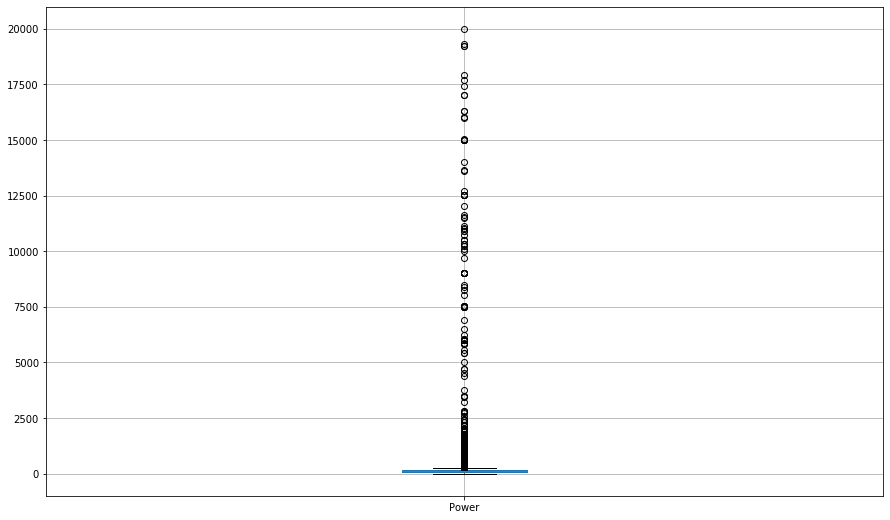

In [15]:
#проверим по boxplot'у выбросы в признаке Мощность
df_model.boxplot('Power', figsize=(15,9))

По условию сказано, что мощность указывается в л.с., в нашем случае выбросов очень много. Согласно последним новостям самый мощный серийный автомобиль был создан японцами мощностью 2000 л.с., а у нас в датасете даже 20 тыс л.с. Не вижу ничего другого как удалить эти строки

In [16]:
#проверим вообще сколько у нас машин, мощность которых больше 900 л.с.
df_model.loc[df_model['Power']>900, 'Power'].count()

313

Всего 313, если потеряем 313 строк из 300 тыс, то ничего не поменяется=)

In [17]:
df_model = df_model.drop(df_model.loc[df_model['Power']>900].index).reset_index(drop=True)

In [18]:
df_model.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [19]:
#функция для замены NaN модой
def replace_nan(df, columns1, columns2, columns3, unique1, unique2):
    for i in unique1:
        for j in unique2:
            if df.loc[((df[columns1] == i) & (df[columns2] == j)), columns3].count() == 0:
                continue
            else:
                df.loc[((df[columns1] == i) & (df[columns2] == j) & (df[columns3].isnull())), columns3] = df.loc[((df[columns1] == i) & (df[columns2] == j)), columns3].mode()[0]
    return df

In [20]:
df_model = replace_nan(df_model, 'Brand', 'Model', 'VehicleType', brand_unique, model_unique)

In [21]:
df_model.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [22]:
#можно посмотреть какого года авто были в ремонте и с каким пробегом и на основе этого мы мы сможем заполнить пропуски
year_unique = df_model['RegistrationYear'].unique()
kilometer_unique = df_model['Kilometer'].unique()

In [23]:
year_unique

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956,
       1941, 1962, 1929, 1957, 1940, 1949, 2019, 1937, 1951, 1953, 1933,
       1950, 1948, 1952, 1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943,
       1934, 1938, 1928, 1919, 1931, 1915, 1920, 1947, 1927, 1946])

In [24]:
kilometer_unique

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

In [25]:
kilometer_yes = df_model.loc[(df['NotRepaired']=='yes'), 'Kilometer']
registration_yes = df_model.loc[(df['NotRepaired']=='yes'), 'RegistrationYear']
kilometer_no = df_model.loc[df_model['NotRepaired']=='no', 'Kilometer']
registration_no = df_model.loc[(df_model['NotRepaired']=='no'), 'RegistrationYear']
kilometer_yes.count()

33392

In [26]:
kilometer_no.count()

211154

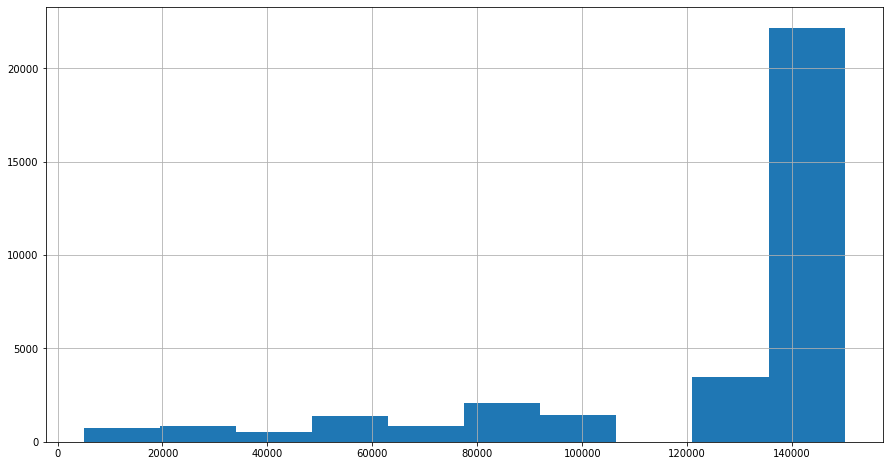

In [27]:
kilometer_yes.hist(bins=10, figsize=(15,8))

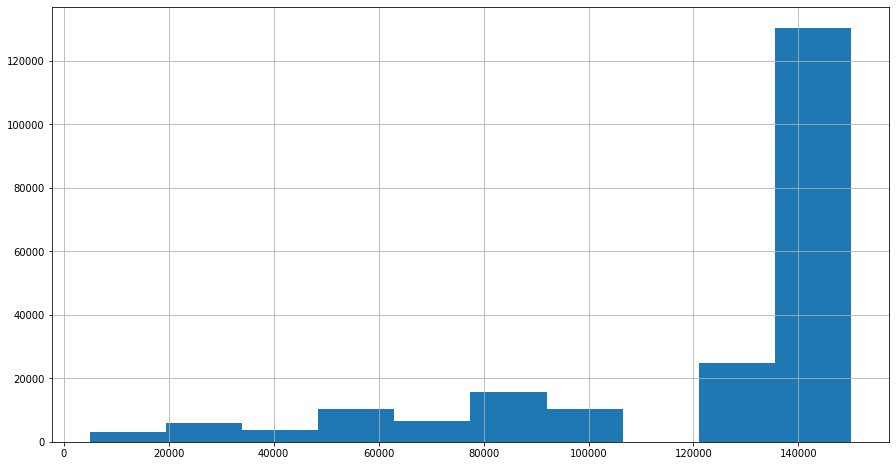

In [28]:
kilometer_no.hist(bins=10, figsize=(15,8))

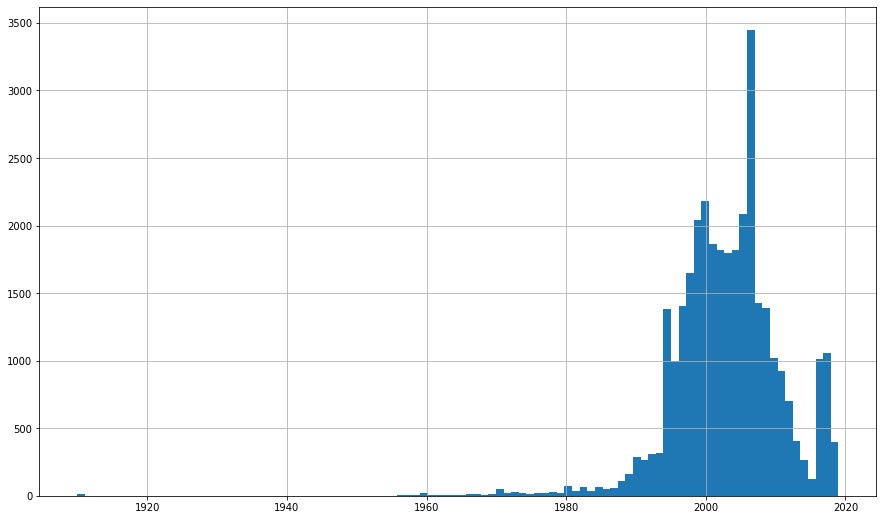

In [29]:
registration_yes.hist(bins=100, figsize=(15,9))

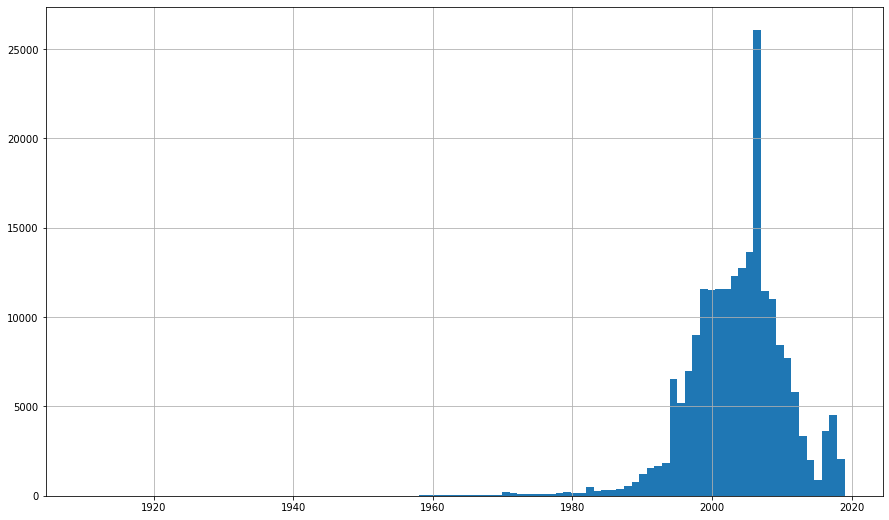

In [30]:
registration_no.hist(bins=100, figsize=(15,9))

Будем считать, если машина старше 2000 года - то ремонт был, если младше 2000 года то - ремонта не было

In [31]:
bools = ['yes', 'no']

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309167 entries, 0 to 309166
Data columns (total 10 columns):
Price               309167 non-null int64
VehicleType         274770 non-null object
RegistrationYear    309167 non-null int64
Gearbox             292092 non-null object
Power               309167 non-null int64
Model               290874 non-null object
Kilometer           309167 non-null int64
FuelType            278524 non-null object
Brand               309167 non-null object
NotRepaired         244750 non-null object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


In [33]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 10 columns):
Price               308854 non-null int64
VehicleType         302882 non-null object
RegistrationYear    308854 non-null int64
Gearbox             291792 non-null object
Power               308854 non-null int64
Model               290596 non-null object
Kilometer           308854 non-null int64
FuelType            278273 non-null object
Brand               308854 non-null object
NotRepaired         244543 non-null object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


In [34]:
df_model.loc[(df_model['NotRepaired'].isnull()) & (df_model['RegistrationYear']<2000), 'NotRepaired'] = bools[0]
df_model.loc[(df_model['NotRepaired'].isnull()) & (df_model['RegistrationYear']>=2000), 'NotRepaired'] = bools[1]

In [35]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 10 columns):
Price               308854 non-null int64
VehicleType         302882 non-null object
RegistrationYear    308854 non-null int64
Gearbox             291792 non-null object
Power               308854 non-null int64
Model               290596 non-null object
Kilometer           308854 non-null int64
FuelType            278273 non-null object
Brand               308854 non-null object
NotRepaired         308854 non-null object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


Тип топлива возьмем по моде по каждому авто и марке авто (аналогия с типом кузова)

In [36]:
df_model = replace_nan(df_model, 'Brand', 'Model', 'FuelType', brand_unique, model_unique)

In [37]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 10 columns):
Price               308854 non-null int64
VehicleType         302882 non-null object
RegistrationYear    308854 non-null int64
Gearbox             291792 non-null object
Power               308854 non-null int64
Model               290596 non-null object
Kilometer           308854 non-null int64
FuelType            302515 non-null object
Brand               308854 non-null object
NotRepaired         308854 non-null object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


In [38]:
df_model = df_model.dropna().reset_index(drop=True)

In [39]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276924 entries, 0 to 276923
Data columns (total 10 columns):
Price               276924 non-null int64
VehicleType         276924 non-null object
RegistrationYear    276924 non-null int64
Gearbox             276924 non-null object
Power               276924 non-null int64
Model               276924 non-null object
Kilometer           276924 non-null int64
FuelType            276924 non-null object
Brand               276924 non-null object
NotRepaired         276924 non-null object
dtypes: int64(4), object(6)
memory usage: 21.1+ MB


In [40]:
df_model.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Итак, имеем 2 датафрейма, 1-ый исходный с Nan'ами (CatBoost согласно документации умеет с ними работать) и 2-й df_model предобработан и не имеет пропусков.

In [41]:
df_learning = df_model.copy()

На данном этапе мы провеле предобработку данных, а именно заполнили пустые ячейки модой (тип кузова, топлива). По гистограммам определили, что в основном ломаются автомобили старше 2003 года, а после они ломались реже. Там где невозможно логично заполнить пустые ячейки, нам пришлось их просто удалить (такова судьба, никуда не деться). Процент потерянных данных около 10%.

<a id='section_id2'></a>

# 2. Обучение моделей

In [42]:
features = df_learning.drop(['Price'], axis=1)
target = df_learning['Price']

In [43]:
#разобьем нашу выборку на обучающую, валидационную и тестовую
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size = 0.5, random_state=12345)

In [44]:
print('Обучающая выборка признаков =', features_train.shape)
print('Валидационная выборка признаков =',features_valid.shape)
print('Тестовая выборка признаков =',features_test.shape)
print('Обучающая выборка целевых признаков =',target_train.shape)
print('Валидационная выборка целевых признаков =',target_valid.shape)
print('Тестовая выборка целевых признаков =',target_test.shape)

Обучающая выборка признаков = (166154, 9)
Валидационная выборка признаков = (55385, 9)
Тестовая выборка признаков = (55385, 9)
Обучающая выборка целевых признаков = (166154,)
Валидационная выборка целевых признаков = (55385,)
Тестовая выборка целевых признаков = (55385,)


In [45]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
max_depth = 10
best_model = None
best_result = 100000000
best_depth = 0
best_estimators = 0

<a id='section_id3'></a>

## 2.1 Градиентный бустинг CatBoost

In [46]:
%%time
for i in range(1, max_depth + 1):
    print('depth =', i)
    model = CatBoostRegressor(loss_function = 'RMSE', depth = i, n_estimators = 200,  random_state = 12345)
    model.fit(features_train, target_train, cat_features = cat_features, verbose = 10)
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    
    if rmse < best_result:
        best_model = model
        best_depth = i
        best_result = rmse
        

depth = 1
0:	learn: 4566.6628502	total: 158ms	remaining: 31.5s
10:	learn: 4239.3908626	total: 1.06s	remaining: 18.2s
20:	learn: 4011.5443950	total: 1.95s	remaining: 16.6s
30:	learn: 3834.5617526	total: 2.85s	remaining: 15.5s
40:	learn: 3692.8777178	total: 3.75s	remaining: 14.5s
50:	learn: 3578.1856572	total: 4.64s	remaining: 13.6s
60:	learn: 3481.5102432	total: 5.54s	remaining: 12.6s
70:	learn: 3399.5440351	total: 6.43s	remaining: 11.7s
80:	learn: 3328.6055448	total: 7.32s	remaining: 10.8s
90:	learn: 3264.9039299	total: 8.21s	remaining: 9.83s
100:	learn: 3206.3621506	total: 9.11s	remaining: 8.93s
110:	learn: 3152.9839298	total: 10s	remaining: 8.02s
120:	learn: 3103.7043618	total: 11s	remaining: 7.18s
130:	learn: 3031.2002406	total: 11.8s	remaining: 6.21s
140:	learn: 2982.4884113	total: 12.7s	remaining: 5.31s
150:	learn: 2942.9405728	total: 13.7s	remaining: 4.44s
160:	learn: 2905.7384987	total: 14.5s	remaining: 3.51s
170:	learn: 2871.9593903	total: 15.4s	remaining: 2.61s
180:	learn: 284

In [47]:
def show(string, best_result, best_depth):
    print('Модель ' + string + ':')
    print()
    print('RMSE =', best_result)
    print('Глубина depth =', best_depth)    

In [48]:
show('CatBoost', best_result, best_depth)

Модель CatBoost:

RMSE = 1836.4065892007131
Глубина depth = 10


Итак, чтобы сделать 10 итераций по глубине дерева - время обучения составляет 13 мин 40 сек. Измерим время обучения и предсказания с подобранными гиперпараметрами.

In [49]:
%%time
best_model.fit(features_train, target_train, cat_features = cat_features, verbose = 10)

0:	learn: 4512.2695614	total: 912ms	remaining: 3m 1s
10:	learn: 3700.5256929	total: 9.71s	remaining: 2m 46s
20:	learn: 3137.3121636	total: 18.3s	remaining: 2m 35s
30:	learn: 2745.4384013	total: 27.1s	remaining: 2m 27s
40:	learn: 2478.5699357	total: 35.8s	remaining: 2m 18s
50:	learn: 2298.3746408	total: 44.8s	remaining: 2m 10s
60:	learn: 2167.7924735	total: 53.2s	remaining: 2m 1s
70:	learn: 2078.4383358	total: 1m 2s	remaining: 1m 52s
80:	learn: 2014.8483628	total: 1m 10s	remaining: 1m 44s
90:	learn: 1970.2558414	total: 1m 19s	remaining: 1m 35s
100:	learn: 1935.3680638	total: 1m 28s	remaining: 1m 26s
110:	learn: 1909.1332401	total: 1m 37s	remaining: 1m 17s
120:	learn: 1889.4410577	total: 1m 46s	remaining: 1m 9s
130:	learn: 1872.7131031	total: 1m 54s	remaining: 1m
140:	learn: 1859.6223937	total: 2m 3s	remaining: 51.6s
150:	learn: 1847.2555874	total: 2m 11s	remaining: 42.8s
160:	learn: 1837.1025613	total: 2m 20s	remaining: 34.1s
170:	learn: 1826.0862860	total: 2m 29s	remaining: 25.3s
180:	

In [50]:
%%time
best_model.predict(features_valid)

CPU times: user 337 ms, sys: 3.82 ms, total: 341 ms
Wall time: 327 ms


array([ 9549.3134991 ,  5603.41031925, 17150.12620747, ...,
        2490.26664486, 14523.65246182,  5885.95331536])

Обучение модели CatBoost составило 2 мин 44 сек, а предсказания всего 255 мс. Проверим как покажется себя классическая модель и LightGBM

In [51]:
#проверим качество на тестовой выборке
predict_test = best_model.predict(features_test)

In [52]:
rmse = mean_squared_error(target_test, predict_test) ** 0.5
rmse

1822.4493210474805

На тестовой выборке rmse даже лучше чем на валидационной

<a id='section_id4'></a>

## 2.2 Случайный лес

In [53]:
#чтобы работать с категориальномы переменными, проведем порядковое кодирование
encoder = OrdinalEncoder()

In [58]:
#проведем кодирование категориальных переменных
df_oe = pd.DataFrame(encoder.fit_transform(df_learning[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]),
                            columns=df_learning[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']].columns)

In [60]:
#перезапишем категориальные столбцы
df_learning[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']] = df_oe

In [61]:
df_learning

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,4.0,1993,1.0,0,116.0,150000,6.0,37.0,1.0
1,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,0.0
2,1500,5.0,2001,1.0,75,116.0,150000,6.0,37.0,0.0
3,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
4,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
276919,3200,4.0,2004,1.0,225,140.0,150000,6.0,30.0,1.0
276920,0,4.0,2005,1.0,0,78.0,150000,6.0,22.0,1.0
276921,1199,1.0,2000,0.0,101,106.0,125000,6.0,32.0,0.0
276922,9200,0.0,1996,1.0,102,224.0,150000,2.0,37.0,0.0


In [63]:
#чтобы не переписывать переменные далее по коду, перезапишем df_oe
df_oe = df_learning

In [64]:
df_oe.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,4.0,1993,1.0,0,116.0,150000,6.0,37.0,1.0
1,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,0.0
2,1500,5.0,2001,1.0,75,116.0,150000,6.0,37.0,0.0
3,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
4,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0


Видим, что категориальные перменные закодировались

In [65]:
best_result = 10000000

In [66]:
features_oe = df_oe.drop(['Price'], axis=1)
target_oe = df_oe['Price']

In [67]:
#разобьем нашу выборку на обучающую, валидационную и тестовую
features_train_oe, features_valid_oe, target_train_oe, target_valid_oe = train_test_split(features_oe, target_oe, test_size = 0.4, random_state=12345)
features_valid_oe, features_test_oe, target_valid_oe, target_test_oe = train_test_split(features_valid_oe, target_valid_oe, test_size = 0.5, random_state=12345)

In [68]:
%%time
for i in range(1,max_depth + 1):
    print('depth =', i)
    model = RandomForestRegressor(n_estimators = 200, max_depth = i, random_state = 12345)
    model.fit(features_train_oe, target_train_oe)
    predictions = model.predict(features_valid_oe)
    rmse = mean_squared_error(target_valid_oe, predictions) ** 0.5
    
    if rmse < best_result:
        best_model = model
        best_depth = i
        best_result = rmse        

depth = 1
depth = 2
depth = 3
depth = 4
depth = 5
depth = 6
depth = 7
depth = 8
depth = 9
depth = 10
CPU times: user 5min 6s, sys: 0 ns, total: 5min 6s
Wall time: 5min 8s


In [69]:
show('случайный лес', best_result, best_depth)

Модель случайный лес:

RMSE = 2017.9625552525565
Глубина depth = 10


In [70]:
%%time
best_model.fit(features_train_oe, target_train_oe)

CPU times: user 52.7 s, sys: 0 ns, total: 52.7 s
Wall time: 53.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [71]:
%%time
best_model.predict(features_valid_oe)

CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.24 s


array([ 9165.1603555 ,  5594.91908621, 16075.6036758 , ...,
        2544.29063088, 14630.33453469,  6279.55307835])

Обучение модели при подборе гиперпараметров всего 5 мин (катбуст 15 мин). rmse всего 2018, у catboostа 1800. Время обучения по подобраным параметрам 53,2с (катбуст 3 минуты).

In [72]:
#проверим качество на тестовой выборке
predict_test_oe = best_model.predict(features_test_oe)

In [73]:
rmse = mean_squared_error(target_test_oe, predict_test_oe) ** 0.5
rmse

2004.8006971949535

Опять же на тестовой выборке результат лучше, чем на валидационной. Проверим LGBMRegressor

<a id='section_id5'></a>

## 2.3 Градиентный бустинг LightGBM

In [74]:
%%time
for i in range(1,max_depth + 1):
    print('depth =', i)
    model = LGBMRegressor(max_depth = i, n_estimators = 200, random_state = 12345)
    model.fit(features_train_oe, target_train_oe)
    predictions = model.predict(features_valid_oe)
    rmse = mean_squared_error(target_valid_oe, predictions) ** 0.5
    
    if rmse < best_result:
        best_model = model
        best_depth = i
        best_result = rmse

depth = 1
depth = 2
depth = 3
depth = 4
depth = 5
depth = 6
depth = 7
depth = 8
depth = 9
depth = 10
CPU times: user 7min 50s, sys: 1.6 s, total: 7min 52s
Wall time: 7min 56s


In [75]:
show('LightGBM', best_result, best_depth)

Модель LightGBM:

RMSE = 1784.1116123508962
Глубина depth = 10


In [76]:
%%time
best_model.fit(features_train_oe, target_train_oe)

CPU times: user 12.2 s, sys: 95.9 ms, total: 12.3 s
Wall time: 12.4 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [77]:
%%time
model.predict(features_valid_oe)

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.29 s


array([ 9519.26449663,  5376.00569942, 17040.10256715, ...,
        2504.08660474, 16029.26348785,  5649.34968866])

Общее время время поиска гиперпараметра depth составило всего 8 минут. Обучение при выбранных параметрах всего 12,5 секунд. RMSE = 1784.

In [78]:
predict_test_oe_light_gbm = best_model.predict(features_test_oe)

In [79]:
rmse = mean_squared_error(target_test_oe, predict_test_oe_light_gbm) ** 0.5
rmse

1761.5913330098608

И опять же на тестовой выборке все гораздо лучше чем на валидационной выборке

# 3. Анализ моделей

Итак, были протестированы 3 модели машинного обучения:<br>
1. Градиентный бустинг библиотеки CatBoost. Скорость обучения и подбора параметров около 15 мин, стандартное отклонение на валидационной выборке 1836 евро, на тесте 1822 евро. Время обучения по найденным параметрам 3 мин, время предсказания 322 мс, очень быстро. <br>
2. Градиентный бустинг LightGBM. Данная модель работает с категориальными переменными с ое кодировкой. Результат получился наилучшим среди трех представленных моделей. Время обучения и поиска параметров 8 минут (быстрее catboost'а, но дольше модели случайного леса), Стандартное отклонение на валидации 1784 евро (лучший результат), на тесте 1766 евро. Время обучения по параметрам 12 секунд, время предсказания 1,29 сек. 
3. Модель Случаный лес. Модель показала наихудшую метрику качества из трех представленных (стандартное отклонение на валидации 2018 евро, на тесте 2004 евро). По скорости обучения и подбора параметров около 5 минут (лучшее время). Обучение по параметрам 53 секунды, быстрее чем у градиентных бустингов. Время предсказания 1,24 секунды. 

Итак, если мы хотим быстро построить модель, то тут модель случайный лес выигрывает у своих конкурентов. Если же мы хотим получить хорошую метрику качества, то тут LightGBM и CatBoost (метрики они показали примерно одинаковые), но LightGBM быстрее ищет параметры и быстрее обучается.